<a href="https://colab.research.google.com/github/zanderharteveld/genesis/blob/main/genesis_example_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genesis
Example Colab Notebook for exploring the protein sequence and fold space using *Genesis*. Methods and Results are described in:

1. [Zander Harteveld, Joshua Southern, Michaël Defferrard, Andreas Loukas, Pierre Vandergheynst, Michael M. Bronstein, Bruno E. Correia. Deep sharpening of topological features for de novo protein design. ICLR MLDD (2022).](https://openreview.net/forum?id=DwN81YIXGQP)

2. [Zander Harteveld, Alexandra Van Hall-Beauvais, Irina Morozova, Joshua Southern, Casper Goverde, Sandrine Georgeon, Stéphane Rosset, Michaël Defferrard, Andreas Loukas, Pierre Vandergheynst, Michael M. Bronstein, and Bruno E. Correia. Exploring "dark matter" protein folds using deep learning. (2023).](https://www.biorxiv.org/content/10.1101/2023.08.30.555621v1)

**Note**: The notebook only creates a low number of trajectories in order to demonstrate how to run *Genesis*. For *de novo* design, it is suggested to run multiple trajectories, as done in the publications.


In [4]:
#@title Install PyRosetta
!pip install pyrosettacolabsetup
import pyrosettacolabsetup; pyrosettacolabsetup.install_pyrosetta()
import pyrosetta; pyrosetta.init()

Mounted at /content/google_drive
Looking for compatible PyRosetta wheel file at google-drive/PyRosetta/colab.bin//wheels...
Found compatible wheel: /content/google_drive/MyDrive/PyRosetta/colab.bin/wheels//content/google_drive/MyDrive/PyRosetta/colab.bin/wheels/pyrosetta-2024.1+release.00b79147e63-cp310-cp310-linux_x86_64.whl


PyRosetta-4 2023 [Rosetta PyRosetta4.MinSizeRel.python310.ubuntu 2024.01+release.00b79147e63be743438188f93a3f069ca75106d6 2023-12-25T16:35:48] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.MinSizeRel.python310.ubuntu r366 2024.01+release.00b79147e63 00b79147e63be743438188f93a3f069ca75106d6 http://www.pyrosetta.org 2023-12-25T16:35:48
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python3.10/dist-packages/pyrosetta/database
basic.random.init_ra

In [5]:
#@title Install dependencies
!pip install scikit-learn transforms3d py3Dmol
!git clone https://github.com/zanderharteveld/genesis.git
%cd genesis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.3 MB/s eta 0:00:00
Cloning into 'genesis'...
remote: Enumerating objects: 99, done.
remote: Total 99 (delta 0), reused 0 (delta 0), pack-reused 99
Receiving objects: 100% (99/99), 241.81 MiB | 16.88 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Updating files: 100% (46/46), done.
/content/genesis


In [14]:
#@title Define helper functions
import os
import sys
import argparse
import re
import glob
import json
import time

import collections
import collections.abc
# Hack, make sure it runs on python 3.6
if not hasattr(collections, 'Iterable'):
    collections.Iterable = collections.abc.Iterable

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from numpy import inf
import pandas as pd

# nn libraries
import torch
from torch import nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

# this library
from source.models import *
from source.utils import *
from minitopobuilder import build_forms, prepare_forms, add_loops

# trDesign
from source.utils_trDesign import *
from source.models_trDesign import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def clean_maps(x, dim):
    dist = x[0].squeeze()[: int(dim), : int(dim), :]
    omega = x[1].squeeze()[: int(dim), : int(dim), :]
    theta = x[2].squeeze()[: int(dim), : int(dim), :]
    phi = x[3].squeeze()[: int(dim), : int(dim), :]
    d = {}
    d["feat"] = {"theta": theta, "phi": phi, "dist": dist, "omega": omega}
    return torch.cat([theta, phi, dist, omega], dim=-1), d


def arrange_maps(m):
    theta = m["feat"][:, :, 0:25]
    phi = m["feat"][:, :, 25:38]
    dist = m["feat"][:, :, 38:75]
    omega = m["feat"][:, :, 75:100]
    m["feat2"] = {"theta": theta, "phi": phi, "dist": dist, "omega": omega}
    return m


def split_feat(feat):
    out = {}
    for k, i, j in [
        ["theta", 0, 25],
        ["phi", 25, 38],
        ["dist", 38, 75],
        ["omega", 75, 100],
    ]:
        out[k] = feat[..., i:j]
    return out


def read_pdb(pdbfile):
    with open(pdbfile, "r") as f:
        lines = f.readlines()
    CA = np.stack(
        [
            np.array(
                [
                    float(line[30:38].strip()),
                    float(line[38:46].strip()),
                    float(line[46:54].strip()),
                ]
            )
            for line in lines
            if line.startswith("ATOM") and line[12:16].strip() == "CA"
        ]
    )
    N = np.stack(
        [
            np.array(
                [
                    float(line[30:38].strip()),
                    float(line[38:46].strip()),
                    float(line[46:54].strip()),
                ]
            )
            for line in lines
            if line.startswith("ATOM") and line[12:16].strip() == "N"
        ]
    )
    C = np.stack(
        [
            np.array(
                [
                    float(line[30:38].strip()),
                    float(line[38:46].strip()),
                    float(line[46:54].strip()),
                ]
            )
            for line in lines
            if line.startswith("ATOM") and line[12:16].strip() == "C"
        ]
    )
    CB = extend(C, N, CA, 1.522, 1.927, -2.143)
    return CA, N, C, CB


def encode_pdb(model3d):
    with open(model3d, "r") as f:
        lines = f.readlines()

    CA = np.stack(
        [
            np.array(
                [
                    float(line[30:38].strip()),
                    float(line[38:46].strip()),
                    float(line[46:54].strip()),
                ]
            )
            for line in lines
            if line.startswith("ATOM") and line[12:16].strip() == "CA"
        ]
    )
    N = np.stack(
        [
            np.array(
                [
                    float(line[30:38].strip()),
                    float(line[38:46].strip()),
                    float(line[46:54].strip()),
                ]
            )
            for line in lines
            if line.startswith("ATOM") and line[12:16].strip() == "N"
        ]
    )
    C = np.stack(
        [
            np.array(
                [
                    float(line[30:38].strip()),
                    float(line[38:46].strip()),
                    float(line[46:54].strip()),
                ]
            )
            for line in lines
            if line.startswith("ATOM") and line[12:16].strip() == "C"
        ]
    )
    CB = extend(C, N, CA, 1.522, 1.927, -2.143)

    dist_ref = to_len(CB[:, None], CB[None, :])
    omega_ref = to_dih(CA[:, None], CB[:, None], CB[None, :], CA[None, :])
    theta_ref = to_dih(N[:, None], CA[:, None], CB[:, None], CB[None, :])
    phi_ref = to_ang(CA[:, None], CB[:, None], CB[None, :])

    dist = mtx2bins(dist_ref, 2.0, 20.0, 37, mask=(dist_ref > 20))
    omega = mtx2bins(omega_ref, -np.pi, np.pi, 25, mask=(dist[..., 0] == 1))
    theta = mtx2bins(theta_ref, -np.pi, np.pi, 25, mask=(dist[..., 0] == 1))
    phi = mtx2bins(phi_ref, 0.0, np.pi, 13, mask=(dist[..., 0] == 1))

    return {"dist": dist, "omega": omega, "theta": theta, "phi": phi}


def calculate_wassterstein_losses_from_maps(
    map1, map2, const_norm, map1_to_torch=False, map2_to_torch=False
):
    if map1_to_torch == True:
        m1dist, m1omega, m1theta, m1phi = (
            torch.from_numpy(map1["dist"]).to(device),
            torch.from_numpy(map1["omega"]).to(device),
            torch.from_numpy(map1["theta"]).to(device),
            torch.from_numpy(map1["phi"]).to(device),
        )
    else:
        m1dist, m1omega, m1theta, m1phi = (
            map1["dist"],
            map1["omega"],
            map1["theta"],
            map1["phi"],
        )
    if map2_to_torch == True:
        m2dist, m2omega, m2theta, m2phi = (
            torch.from_numpy(map2["dist"]).to(device),
            torch.from_numpy(map2["omega"]).to(device),
            torch.from_numpy(map2["theta"]).to(device),
            torch.from_numpy(map2["phi"]).to(device),
        )
    else:
        m2dist, m2omega, m2theta, m2phi = (
            map2["dist"],
            map2["omega"],
            map2["theta"],
            map2["phi"],
        )

    w1_dist = torch_wasserstein_loss(m1dist.to(device), m2dist.to(device)).sum() / const_norm.to(device)
    w1_omega = torch_wasserstein_loss(m1omega.to(device), m2omega.to(device)).sum() / const_norm.to(device)
    w1_theta = torch_wasserstein_loss(m1theta.to(device), m2theta.to(device)).sum() / const_norm.to(device)
    w1_phi = torch_wasserstein_loss(m1phi.to(device), m2phi.to(device)).sum() / const_norm.to(device)
    w1 = (w1_dist + w1_omega + w1_theta + w1_phi) / 4
    return w1_dist.item(), w1_omega.item(), w1_theta.item(), w1_phi.item(), w1.item()


def run_main(args):
    """
    Main execution point.
    """
    topology = args.form
    if not topology.endswith(".pdb"):
        total_topology_size = sum([int(e[3:]) for e in topology.split(".")])
        architecture = topology.split(".")
        architecture.sort(key=natural_keys)
        architecture = ".".join(architecture)
        loops = args.loops
        total_loop_size = sum([int(e) for e in loops.split(".") if e != "x"])
    else:
        topology = topology.replace(".pdb", "-pdb")
        total_topology_size = 00
        architecture = "xx"
        loops = args.loops
        total_loop_size = 00

    num_decoys = args.num_decoys
    num_recycling = args.num_recycling
    wts = args.wts
    prefix = args.prefix
    out_dir = args.out_dir
    bypass = args.bypass
    bypass_trD = args.bypassTrD
    free_relax = args.free_relax
    add_aa_comp = args.add_aa_comp
    poly_val = args.polyVAL_seq
    optimizer_trD = args.optimizer
    opt_iterations_trD = args.opt_iterations
    pssm_design = args.pssm_design
    n_seqs_for_pssm = args.n_seqs_for_pssm

    # Log info
    print(
        "#############################################################################"
    )
    print("description: {}_{}_{}".format(prefix, topology, loops))
    print("FORM: {}".format(topology))
    print("loops: {}".format(loops))
    print("bypassing GENESIS: {}".format(bypass))
    print("bypassing trDesign: {}".format(bypass_trD))
    print("force poly-Valine instead of trDesign sequence: {}".format(poly_val))
    print("adding AA composition loss: {}".format(add_aa_comp))
    print("trDesign optimizer: {}".format(optimizer_trD))
    print("number of trDesign optimization iterations: {}".format(opt_iterations_trD))
    print("adding final free relax to pyrosetta protocol: {}".format(free_relax))
    print("total length (max. 128AA): {}".format(total_topology_size + total_loop_size))
    print("fixed-point iterative recyclings: {}".format(num_recycling))
    print("number of decoys to generate: {}".format(num_decoys))
    print("hybrid design (PSSM based): {}".format(pssm_design))
    print("saving to {} with prefix {}".format(out_dir, prefix))
    print(
        "#############################################################################"
    )
    print("")

    # Load Genesis model
    lr, epoch_step = 1e-3, 500
    encoder = Encoder2(image_channels=4, image_shape=128, hidden=2304, latent=128)
    decoder = Decoder2(image_channels=4, image_shape=128, hidden=2304, latent=128)
    model_genesis = Model2(Encoder=encoder, Decoder=decoder).to(device)

    optimizer = Adam(model_genesis.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=epoch_step, gamma=0.99)
    try:
        checkpoint = torch.load(wts, map_location=torch.device(device))
    except:
        wts = os.path.join(top_folder, wts)
        checkpoint = torch.load(wts, map_location=torch.device(device))

    epoch, train_loss_mean = checkpoint["epoch"], checkpoint["loss"]
    model_genesis.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    if not topology.endswith("-pdb"):
        # Build sketch
        container = build_forms(
            architecture,
            connectivity=topology,
            links=loops,
            link_distance_add=15.0,
            check_forms=False,
            verbose=1,
        )
        sketches = prepare_forms(container, two_way=True)
        sketchNoLoops = (
            sketches[(sketches.description == topology) & (sketches.direction == "+")]
            .iloc[0]
            .naive
        )
        # sketchn  = sketches[(sketches.description == topology) & (sketches.direction == '-')].iloc[0].naive

        sse = "".join([e[2] * int(e[3:]) * 4 for e in topology.split(".")])
        layer = "".join([e[0] * int(e[3:]) * 4 for e in topology.split(".")])
        layer_element = "".join([e[1] * int(e[3:]) * 4 for e in topology.split(".")])
        sketchNoLoops["secstruct"] = list(sse)
        sketchNoLoops["layer"] = list(layer)
        sketchNoLoops["layer_element"] = [int(e) for e in layer_element]
        sketch = add_loops(sketchNoLoops, verbose=False)
        # Report loops in case lengths were not given
        coarse_grain_seq = "".join(
            [
                e
                for k, e in zip(sketch.atomtype.values, sketch.res1aa.values)
                if k.strip() == "CA"
            ]
        )
        coarse_loops = [str(len(e)) for e in coarse_grain_seq.split("V") if e != ""]
        coarse_loops = "x." + ".".join(coarse_loops) + ".x"

        # Save sketches
        write_pdb(
            sketchNoLoops,
            action="write",
            outfile=os.path.join(
                out_dir, "{}_{}_{}_+_sketchXnoloops.pdb".format(prefix, topology, loops)
            ),
        )
        # write_pdb( sketchn, action='write', outfile=os.path.join( out_dir, '{}_{}_{}_-_sketchXnoloops.pdb'.format(prefix, topology, loops)))
        write_pdb(
            sketch,
            action="write",
            outfile=os.path.join(
                out_dir, "{}_{}_{}_sketchXloops.pdb".format(prefix, topology, loops)
            ),
        )

        # Encode
        sketch_ca = pad1d_map(
            torch.from_numpy(sketch[sketch.atomtype == "CA"][["x", "y", "z"]].values)
        ).unsqueeze(0)
        sketch_c = pad1d_map(
            torch.from_numpy(sketch[sketch.atomtype == "C"][["x", "y", "z"]].values)
        ).unsqueeze(0)
        sketch_n = pad1d_map(
            torch.from_numpy(sketch[sketch.atomtype == "N"][["x", "y", "z"]].values)
        ).unsqueeze(0)
        dim = torch.tensor(
            len(sketch[sketch.atomtype == "CA"][["x", "y", "z"]])
        ).unsqueeze(0)
        xenc, mask, dim_enc = encode_x_on_gpu(
            (dim, (sketch_ca, sketch_c, sketch_n))
        )  # [batch, 4, dim1, dim2]
        sdist = mtx2bins_torch(
            xenc[:, 0, : int(dim), : int(dim)].squeeze(),
            2.0,
            20.0,
            37,
            mask=(xenc[:, 2, : int(dim), : int(dim)].squeeze() > 20),
        )
        somega = mtx2bins_torch(
            xenc[:, 1, : int(dim), : int(dim)].squeeze(),
            -np.pi,
            np.pi,
            25,
            mask=(sdist[..., 0] == 1),
        )
        stheta = mtx2bins_torch(
            xenc[:, 2, : int(dim), : int(dim)].squeeze(),
            -np.pi,
            np.pi,
            25,
            mask=(sdist[..., 0] == 1),
        )
        sphi = mtx2bins_torch(
            xenc[:, 3, : int(dim), : int(dim)].squeeze(),
            0.0,
            np.pi,
            13,
            mask=(sdist[..., 0] == 1),
        )
        smaps = {}
        smaps["feat"] = {"theta": stheta, "phi": sphi, "dist": sdist, "omega": somega}
    else:
        smaps = {}
        ss = encode_pdb(topology.replace("-pdb", ".pdb"))
        sdist = torch.from_numpy(ss["dist"])
        somega = torch.from_numpy(ss["omega"])
        stheta = torch.from_numpy(ss["theta"])
        sphi = torch.from_numpy(ss["phi"])
        smaps["feat"] = {"theta": stheta, "phi": sphi, "dist": sdist, "omega": somega}
        sketch_cai, sketch_c, sketch_n, sketch_cb = read_pdb(
            topology.replace("-pdb", ".pdb")
        )
        sketch_ca = pad1d_map(torch.from_numpy(sketch_cai)).unsqueeze(0)
        sketch_c = pad1d_map(torch.from_numpy(sketch_c)).unsqueeze(0)
        sketch_n = pad1d_map(torch.from_numpy(sketch_n)).unsqueeze(0)
        dim = torch.tensor(len(sketch_cai)).unsqueeze(0)
        xenc, mask, dim_enc = encode_x_on_gpu((dim, (sketch_ca, sketch_c, sketch_n)))

    # Save input map
    ifeats = {
        "dist": xenc[:, 0, : int(dim), : int(dim)].detach().cpu().numpy(),
        "theta": xenc[:, 1, : int(dim), : int(dim)].detach().cpu(),
        "omega": xenc[:, 2, : int(dim), : int(dim)].detach().cpu(),
        "phi": xenc[:, 3, : int(dim), : int(dim)].detach().cpu(),
    }
    np.savez_compressed(
        os.path.join(
            out_dir, "{}_{}_{}_sketch-maps.npz".format(prefix, topology, loops)
        ),
        **ifeats
    )
    fig, axs = plt.subplots(1, 4, figsize=(9, 4))
    axs[0].imshow(xenc[:, 0, : int(dim), : int(dim)].squeeze().detach().cpu().numpy())  # distance
    axs[1].imshow(xenc[:, 1, : int(dim), : int(dim)].squeeze().detach().cpu().numpy())  # omega
    axs[2].imshow(xenc[:, 2, : int(dim), : int(dim)].squeeze().detach().cpu().numpy())  # theta
    axs[3].imshow(xenc[:, 3, : int(dim), : int(dim)].squeeze().detach().cpu().numpy())  # phi
    plt.tight_layout()
    plt.savefig(
        os.path.join(out_dir, "{}_{}_{}_sketch.png".format(prefix, topology, loops)),
        dpi=75,
    )

    if not bypass:
        # Predict
        model_genesis.eval()
        for reci in range(1 + num_recycling):
            xenc, mean, log_var = model_genesis(xenc)
            maps_in, tmaps = clean_maps(xenc, dim)  # [dim1, dim2, 100]

            # Recover approx. real values
            xdist_r = bins2real(xenc[0].squeeze(), 2, 20, 37, mask, add_bin=True)
            xomega_r = bins2real(xenc[1].squeeze(), -np.pi, np.pi, 25, mask)
            xtheta_r = bins2real(xenc[2].squeeze(), -np.pi, np.pi, 25, mask)
            xphi_r = bins2real(xenc[3].squeeze(), 0, np.pi, 13, mask)
            xenc = torch.stack([xdist_r, xomega_r, xtheta_r, xphi_r], dim=1)

            # Save genesis map
            gfeats = split_feat(maps_in.detach().cpu().numpy())
            np.savez_compressed(
                os.path.join(
                    out_dir,
                    "{}_{}_{}_{}_genesis-maps.npz".format(
                        prefix, topology, loops, reci
                    ),
                ),
                **gfeats
            )
            fig, axs = plt.subplots(1, 4, figsize=(9, 4))
            axs[0].imshow(maps_in[:, :, 38:75].argmax(-1).detach().cpu().numpy())  # distance
            axs[1].imshow(maps_in[:, :, 75:100].argmax(-1).detach().cpu().numpy())  # omega
            axs[2].imshow(maps_in[:, :, 0:25].argmax(-1).detach().cpu().numpy())  # theta
            axs[3].imshow(maps_in[:, :, 25:38].argmax(-1).detach().cpu().numpy())  # phi
            plt.tight_layout()
            plt.savefig(
                os.path.join(
                    out_dir,
                    "{}_{}_{}_{}_genesis.png".format(prefix, topology, loops, reci),
                ),
                dpi=75,
            )
    else:
        maps_in = torch.cat([stheta, sphi, sdist, somega], dim=-1)
        tmaps = {}
        tmaps["feat"] = {"theta": stheta, "phi": sphi, "dist": sdist, "omega": somega}

    # To NumPy
    maps_in = maps_in.detach().cpu().numpy()
    shape_norm = dim * dim

    if not bypass_trD:
        # Design using gradients
        trDesign_dir = os.path.join(top_folder, "./data/models_trRosetta/")
        if add_aa_comp == True:
            model_trRosetta = mk_design_model(
                add_pdb=True,
                add_aa_comp=True,
                n_models=5,
                DB_DIR=trDesign_dir,
                msa_design=pssm_design,
                feat_drop=0.8,
            )
        else:
            model_trRosetta = mk_design_model(
                add_pdb=True,
                n_models=5,
                DB_DIR=trDesign_dir,
                msa_design=pssm_design,
                feat_drop=0.8,
            )
        maps_out = model_trRosetta.design(
            inputs={"pdb": maps_in[None]},
            return_traj=False,
            shuf=True,
            verbose=True,
            opt_method=optimizer_trD,  # "GD", "GD_decay", "ADAM"
            opt_iter=opt_iterations_trD,  # 101
            num=n_seqs_for_pssm,  # number of sequences to design
            weights=None,
            rm_aa=None,
            # b1=0.9, b2=0.999, opt_rate=1.0, opt_decay=2.0
        )
        trD_score = -0.25 * (maps_in * np.log(maps_out["feat"])).sum(-1).mean()

        # Save trDesign map
        trDfeats = split_feat(maps_out["feat"])
        np.savez_compressed(
            os.path.join(
                out_dir, "{}_{}_{}_trDesign-maps.npz".format(prefix, topology, loops)
            ),
            **trDfeats
        )
        fig, axs = plt.subplots(1, 4, figsize=(9, 4))
        axs[0].imshow(maps_out["feat"][:, :, 38:75].argmax(-1))  # distance
        axs[1].imshow(maps_out["feat"][:, :, 75:100].argmax(-1))  # omega
        axs[2].imshow(maps_out["feat"][:, :, 0:25].argmax(-1))  # theta
        axs[3].imshow(maps_out["feat"][:, :, 25:38].argmax(-1))  # phi
        plt.tight_layout()
        plt.savefig(
            os.path.join(
                out_dir, "{}_{}_{}_trDesign.png".format(prefix, topology, loops)
            ),
            dpi=75,
        )

        # Compute evaluation score
        # Here, sum of the 1st Wasserstein distance between the distributions (pixel-wise 1-w distance)
        # Between maps of Sketch-Genesis, Sketch-TrDes, Genesis-TrDes
        maps_out = arrange_maps(maps_out)
        (
            w1_dist_GToTrD,
            w1_omega_GToTrD,
            w1_theta_GToTrD,
            w1_phi_GToTrD,
            w1_GToTrD,
        ) = calculate_wassterstein_losses_from_maps(
            tmaps["feat"],
            maps_out["feat2"],
            shape_norm,
            map1_to_torch=False,
            map2_to_torch=True,
        )
        print("W1 Genesis <--> TrDesign")
        print("wA_dist(Genesis,TrDes)  = {}".format(w1_dist_GToTrD))
        print("w1_omega(Genesis,TrDes) = {}".format(w1_omega_GToTrD))
        print("w1_theta(Genesis,TrDes) = {}".format(w1_theta_GToTrD))
        print("w1_phi(Genesis,TrDes)   = {}".format(w1_phi_GToTrD))
        print("MEAN w1(Genesis,TrDes)  = {}".format(w1_GToTrD))

        (
            w1_dist_SToTrD,
            w1_omega_SToTrD,
            w1_theta_SToTrD,
            w1_phi_SToTrD,
            w1_SToTrD,
        ) = calculate_wassterstein_losses_from_maps(
            smaps["feat"],
            maps_out["feat2"],
            shape_norm,
            map1_to_torch=False,
            map2_to_torch=True,
        )
        print("W1 Sketch <--> TrDesign")
        print("w1_dist(Sketch,TrDes)  = {}".format(w1_dist_SToTrD))
        print("w1_omega(Sketch,TrDes) = {}".format(w1_omega_SToTrD))
        print("w1_theta(Sketch,TrDes) = {}".format(w1_theta_SToTrD))
        print("w1_phi(Sketch,TrDes)   = {}".format(w1_phi_SToTrD))
        print("MEAN w1(Sketch,TrDes)  = {}".format(w1_SToTrD))

        # seq = N_to_AA(maps_out["I"][0].argmax(-1))[0]
        seqs = [seq[: int(dim)] for seq in N_to_AA(maps_out["I"].argmax(-1))]
        # select best sequence based on lowest content of CYS and MET
        seq = seqs[np.argmin([seq.count("M") + seq.count("C") for seq in seqs])]
        msa_path = os.path.join(out_dir, "{}_{}_{}.msa".format(prefix, topology, loops))
        with open(msa_path, "w") as f:
            f.write("sequence\n")
            for s in seqs:
                f.write("{}\n".format(s))

        if pssm_design == True:
            # let's generate the pssm
            pssm_raw = trRosettaOut2pssm(msa_path)
            pssm_path = os.path.join(
                out_dir, "{}_{}_{}.pssm".format(prefix, topology, loops)
            )
            save_pssm(pssm_raw, pssm_path)
    else:
        w1_dist_GToTrD, w1_omega_GToTrD, w1_theta_GToTrD, w1_phi_GToTrD, w1_GToTrD = (
            "NaN",
            "NaN",
            "NaN",
            "NaN",
            "NaN",
        )
        w1_dist_SToTrD, w1_omega_SToTrD, w1_theta_SToTrD, w1_phi_SToTrD, w1_SToTrD = (
            "NaN",
            "NaN",
            "NaN",
            "NaN",
            "NaN",
        )
        trD_score = "NaN"
        maps_in = np.nan_to_num(maps_in, nan=0, neginf=0, posinf=0)
        maps_in[maps_in < 1e-21] = 1e-21  # avoid -inf

        theta, phi, dist, omega = (
            maps_in[:, :, 0:25],
            maps_in[:, :, 25:38],
            maps_in[:, :, 38:75],
            maps_in[:, :, 75:100],
        )
        seqs = ["V" * maps_in.shape[0]]
        seq = seqs[0]
        maps_out = {
            "feat2": {"theta": theta, "phi": phi, "dist": dist, "omega": omega},
            "I": seq,
        }
        msa_path = os.path.join(out_dir, "{}_{}_{}.msa".format(prefix, topology, loops))
        with open(msa_path, "w") as f:
            f.write("sequence\n")
            for s in seqs * 10:
                f.write("{}\n".format(s))
        if pssm_design == True:
            # let's generate the pssm
            pssm_raw = trRosettaOut2pssm(msa_path)
            pssm_path = os.path.join(
                out_dir, "{}_{}_{}.pssm".format(prefix, topology, loops)
            )
            save_pssm(pssm_raw, pssm_path)

    # Force a poly-VAL sequence
    if poly_val == True:
        seqs = ["V" * int(dim)]
        seq = seqs[0]
        maps_out["I"] = seq

    # Rosetta 3D model generation
    # Build the 3D model from the generated feature maps
    # They will be used to guide the GD within the Rosetta force field
    if not topology.endswith("-pdb"):
        sse, ss_pairs, hh_pairs, hss_triplets = (
            get_sse(topology, coarse_loops),
            get_ss_pairs(topology),
            get_hh_pairs(topology),
            get_hss_triplets(topology),
        )
    else:
        sse, ss_pairs, hh_pairs, hss_triplets = "", "", "", ""
    struc_info_path = os.path.join(
        out_dir, "{}_{}_{}.strucinfo".format(prefix, topology, loops)
    )
    with open(struc_info_path, "w") as f:
        f.write(
            "{}\n{}\n{}\n{}".format(
                sse, ";".join(ss_pairs), ";".join(hh_pairs), ";".join(hss_triplets)
            )
        )

    frames = []
    for n in range(num_decoys):
        pose_path = os.path.join(
            out_dir, "{}_{}_{}_{}.pdb".format(prefix, topology, loops, n)
        )
        if pssm_design == True:
            pose = pyrosetta_design(
                maps_out,
                pose_path,
                # sse=sse, ss_pairs=ss_pairs, hh_pairs='', add_free_relax=free_relax, pssm=pssm_path )
                # sse=sse, ss_pairs=ss_pairs, hh_pairs=hh_pairs, add_free_relax=free_relax, pssm=pssm_path )
                sse=sse,
                ss_pairs=ss_pairs,
                hh_pairs=hh_pairs,
                hss_triplets=hss_triplets,
                add_free_relax=free_relax,
                pssm=pssm_path,
            )
        else:
            pose = pyrosetta_design(
                maps_out,
                pose_path,
                sse=sse,
                ss_pairs=ss_pairs,
                hh_pairs=hh_pairs,
                hss_triplets=hss_triplets,
                add_free_relax=free_relax,
            )
        df_scores = pd.DataFrame.from_records(dict(pose.scores), index=[n])

        # Compute scores to maps
        model_map = encode_pdb(pose_path)
        (
            w1_dist_GToM,
            w1_omega_GToM,
            w1_theta_GToM,
            w1_phi_GToM,
            w1_GToM,
        ) = calculate_wassterstein_losses_from_maps(
            tmaps["feat"],
            model_map,
            shape_norm,
            map1_to_torch=False,
            map2_to_torch=True,
        )
        print("w1_dist(Genesis,Model)  = {}".format(w1_dist_GToM))
        print("w1_omega(Genesis,Model) = {}".format(w1_omega_GToM))
        print("w1_theta(Genesis,Model) = {}".format(w1_theta_GToM))
        print("w1_phi(Genesis,Model)   = {}".format(w1_phi_GToM))
        print("Mean w1(Genesis,Model)  = {}".format(w1_GToM))
        (
            w1_dist_SToM,
            w1_omega_SToM,
            w1_theta_SToM,
            w1_phi_SToM,
            w1_SToM,
        ) = calculate_wassterstein_losses_from_maps(
            smaps["feat"],
            model_map,
            shape_norm,
            map1_to_torch=False,
            map2_to_torch=True,
        )
        print("w1_dist(Sketch,Model)  = {}".format(w1_dist_SToM))
        print("w1_omega(Sketch,Model) = {}".format(w1_omega_SToM))
        print("w1_theta(Sketch,Model) = {}".format(w1_theta_SToM))
        print("w1_phi(Sketch,Model)   = {}".format(w1_phi_SToM))
        print("Mean w1(Sketch,Model)  = {}".format(w1_SToM))
        print("TOTAL w1 drop Sketch <--> Genesis: {}".format(w1_GToM - w1_SToM))

        df_scores = df_scores.assign(
            trDesign_score=[trD_score] * len(df_scores),
            w1_dist_GTrD=[w1_dist_GToTrD] * len(df_scores),
            w1_omega_GTrD=[w1_omega_GToTrD] * len(df_scores),
            w1_theta_GTrD=[w1_theta_GToTrD] * len(df_scores),
            w1_phi_GTrD=[w1_phi_GToTrD] * len(df_scores),
            w1_GTrD=[w1_GToTrD] * len(df_scores),
            w1_dist_STrD=[w1_dist_SToTrD] * len(df_scores),
            w1_omega_STrD=[w1_omega_SToTrD] * len(df_scores),
            w1_theta_STrD=[w1_theta_SToTrD] * len(df_scores),
            w1_phi_STrD=[w1_phi_SToTrD] * len(df_scores),
            w1_STrD=[w1_SToTrD] * len(df_scores),
            w1_dist_GM=[w1_dist_GToM] * len(df_scores),
            w1_omega_GM=[w1_omega_GToM] * len(df_scores),
            w1_theta_GM=[w1_theta_GToM] * len(df_scores),
            w1_phi_GM=[w1_phi_GToM] * len(df_scores),
            w1_GM=[w1_GToM] * len(df_scores),
            w1_dist_SM=[w1_dist_SToM] * len(df_scores),
            w1_omega_SM=[w1_omega_SToM] * len(df_scores),
            w1_theta_SM=[w1_theta_SToM] * len(df_scores),
            w1_phi_SM=[w1_phi_SToM] * len(df_scores),
            w1_SM=[w1_SToM] * len(df_scores),
            description=["{}_{}_{}_{}.pdb".format(prefix, topology, loops, n)]
            * len(df_scores),
        )
        frames.append(df_scores)
    dfs = pd.concat(frames)
    dfs.to_csv(
        os.path.join(out_dir, "{}_{}_{}_scores.csv".format(prefix, topology, loops))
    )

In [15]:
#@title Input parameters
top_folder = "./"

output_folder = '/content/output/'
isExist = os.path.exists(output_folder)
if not isExist:
  os.makedirs(output_folder)
else:
  files = glob.glob(output_folder + '/*')
  for f in files:
    os.remove(f)

#@markdown **Parameters**

#@markdown **Note**: The max length is 128 amino-acids.
fold_form = "A1H9.A2H9.B1H9"  #@param {type:"string"}
loops = "x.6.6.x"  #@param {type:"string"}
num_decoys = 1  #@param {type:"integer"}
opt_iterations = 101  #@param {type:"integer"}
num_recycling = 0  # default
wts = "./data/finetune_checkpoint_500"  # default
prefix = "design"  #@param {type:"string"}
output_directory = "/content/output/"  # default
bypass_genesis = False  #@param {type:"boolean"}
bypass_trRosetta = False  #@param {type:"boolean"}
final_relax = False #@param {type:"boolean"}
add_aminoacid_composition_loss = False  #@param {type:"boolean"}
optimizer = "ADAM"  # default
polyVAL_seq = False  # default
pssm_design = True  # default
n_seqs_for_pssm = 1000  # default


class Args:
    def __init__(
          self,
          fold_form,
          loops,
          num_decoys,
          opt_iterations,
          num_recycling,
          wts,
          prefix,
          output_directory,
          bypass_genesis,
          bypass_trRosetta,
          final_relax,
          add_aminoacid_composition_loss,
          optimizer,
          polyVAL_seq,
          pssm_design,
          n_seqs_for_pssm
        ):
        self.form = fold_form
        self.loops = loops
        self.num_decoys = num_decoys
        self.num_recycling = num_recycling
        self.wts = wts
        self.prefix = prefix
        self.out_dir = output_directory
        self.bypass = bypass_genesis
        self.bypassTrD = bypass_trRosetta
        self.free_relax = final_relax
        self.add_aa_comp = add_aminoacid_composition_loss
        self.optimizer = optimizer
        self.opt_iterations = opt_iterations
        self.polyVAL_seq = polyVAL_seq
        self.pssm_design = pssm_design
        self.n_seqs_for_pssm = n_seqs_for_pssm

args = Args(
    fold_form=fold_form,
    loops=loops,
    num_decoys=num_decoys,
    opt_iterations=opt_iterations,
    num_recycling=num_recycling,
    wts=wts,
    prefix=prefix,
    output_directory=output_directory,
    bypass_genesis=bypass_genesis,
    bypass_trRosetta=bypass_trRosetta,
    final_relax=final_relax,
    add_aminoacid_composition_loss=add_aminoacid_composition_loss,
    optimizer=optimizer,
    polyVAL_seq=polyVAL_seq,
    pssm_design=pssm_design,
    n_seqs_for_pssm=n_seqs_for_pssm
)

#############################################################################
description: design_A1H9.A2H9.B1H9_x.6.6.x
FORM: A1H9.A2H9.B1H9
loops: x.6.6.x
bypassing GENESIS: False
bypassing trDesign: False
force poly-Valine instead of trDesign sequence: False
adding AA composition loss: False
trDesign optimizer: ADAM
number of trDesign optimization iterations: 101
adding final free relax to pyrosetta protocol: False
total length (max. 128AA): 39
fixed-point iterative recyclings: 0
number of decoys to generate: 1
hybrid design (PSSM based): True
saving to /content/output/ with prefix design
#############################################################################

+ directions are [0, 1, 0]
- directions are [1, 0, 1]
mode: msa design
loading model: xaa
loading model: xab
loading model: xac
loading model: xad
loading model: xae
add_aa_ref: False, add_aa_comp: False, add_aa_comp_old: False
The loss function is composed of the following: ['pdb']


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10 loss:{'pdb':2.5811021}
20 loss:{'pdb':2.4343758}
30 loss:{'pdb':2.3624196}
40 loss:{'pdb':2.324998}
50 loss:{'pdb':2.3578928}
60 loss:{'pdb':2.3343153}
70 loss:{'pdb':2.2926302}
80 loss:{'pdb':2.4990058}
90 loss:{'pdb':2.303367}
100 loss:{'pdb':2.306209}
FINAL loss:{'pdb':2.4680731}
W1 Genesis <--> TrDesign
wA_dist(Genesis,TrDes)  = 5.576413154602051
w1_omega(Genesis,TrDes) = 5.253268241882324
w1_theta(Genesis,TrDes) = 4.491105079650879
w1_phi(Genesis,TrDes)   = 1.8758699893951416
MEAN w1(Genesis,TrDes)  = 4.299164295196533
W1 Sketch <--> TrDesign
w1_dist(Sketch,TrDes)  = 7.392083168029785
w1_omega(Sketch,TrDes) = 7.088862895965576
w1_theta(Sketch,TrDes) = 6.561100482940674
w1_phi(Sketch,TrDes)   = 2.503129243850708
MEAN w1(Sketch,TrDes)  = 5.886293888092041
PyRosetta-4 2023 [Rosetta PyRosetta4.MinSizeRel.python310.ubuntu 2024.01+release.00b79147e63be743438188f93a3f069ca75106d6 2023-12-25T16:35:48] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institu

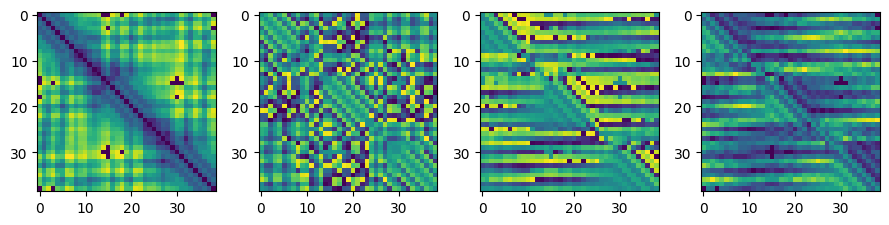

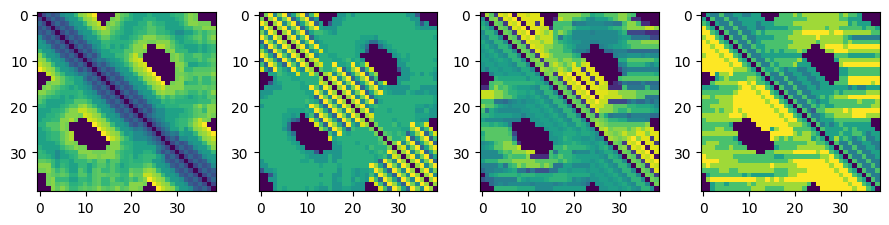

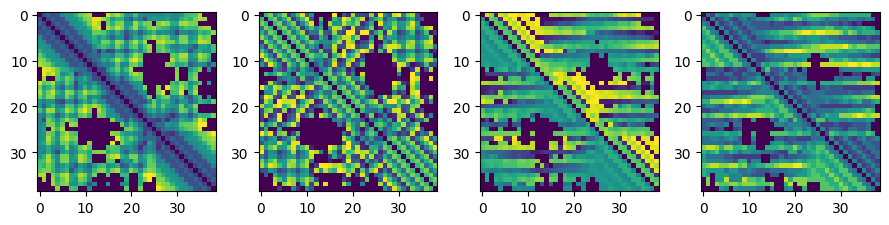

In [16]:
#@title Main execution --- this might take some time depending on the device your are using...
run_main(args)

In [17]:
#@title Visualize your newly designed protein!
import glob
import py3Dmol

view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
pdb_str = open([p for p in glob.iglob("/content/output/*_0.pdb")][0],'r').read()
view.addModel(pdb_str,'pdb',) # {'hbondCutoff':hbondCutoff}

view.setStyle({"model":0},{'cartoon':{}}) #: {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [24]:
#@title Download the predictions
from google.colab import files

!zip -r /content/output/output.zip /content/output
files.download("/content/output/output.zip")

updating: content/output/ (stored 0%)
updating: content/output/design_A1H9.A2H9.B1H9_x.6.6.x.strucinfo (deflated 60%)
updating: content/output/design_A1H9.A2H9.B1H9_x.6.6.x_0.pdb (deflated 76%)
updating: content/output/design_A1H9.A2H9.B1H9_x.6.6.x_0_genesis.png (deflated 10%)
updating: content/output/design_A1H9.A2H9.B1H9_x.6.6.x_0_genesis-maps.npz (deflated 0%)
updating: content/output/design_A1H9.A2H9.B1H9_x.6.6.x_trDesign.png (deflated 8%)
updating: content/output/design_A1H9.A2H9.B1H9_x.6.6.x_scores.csv (deflated 46%)
updating: content/output/design_A1H9.A2H9.B1H9_x.6.6.x_+_sketchXnoloops.pdb (deflated 83%)
updating: content/output/design_A1H9.A2H9.B1H9_x.6.6.x_0.xml (deflated 81%)
updating: content/output/design_A1H9.A2H9.B1H9_x.6.6.x_sketchXloops.pdb (deflated 82%)
updating: content/output/design_A1H9.A2H9.B1H9_x.6.6.x_0_onlyMin.pdb (deflated 79%)
updating: content/output/design_A1H9.A2H9.B1H9_x.6.6.x_sketch.png (deflated 7%)
updating: content/output/design_A1H9.A2H9.B1H9_x.6.6.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>